This notebook compares annotations using different GLLMs with codebooks based prompts of Boukes 2024, Jaidka 2022 and Naab 2025 on their respective datasets

In [2]:
import requests
import os
from dotenv import load_dotenv
load_dotenv("sjoerdAzure.env")  # Load environment variables from .env file
import time

import typing

from sklearn.metrics import cohen_kappa_score, classification_report
import krippendorff
import yaml

import pandas as pd

import config
import src
import tqdm
import json
import numpy as np
import logging

#import cltrier_lib as lib
import pyreadstat
import yaml
pd.set_option('display.max_colwidth', 100) 
#set up helper variables and functions:
CFG = config.Config()

import matplotlib.pyplot as plt
import itertools
from matplotlib_venn import venn3
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency, fisher_exact
import statsmodels.api as sm
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
import warnings
warnings.filterwarnings('ignore')



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\sstolwi\Github\llmdiv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\sstolwi\Github\llmdiv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\sstolwi\Github\llmdiv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\sstolwi\Git

In [3]:
# Define the mapping from concept to ground truth column
boukes_concepts_info = [
    ('Incivility', 'INCIVILITY_DUMMY'),
    ('Rationality', 'RATIONALITY_DUMMY'),
    ('Interactivity', 'INTERACTIVITY_DUMMY'),
    ('Liberal', 'LIBERAL_DUMMY'),
    ('Conservative', 'CONSERVATIVE_DUMMY'),
    ('Political Post', 'TopicRelevance')
]

# Helper: get ground truth column for a concept
def get_ground_truth_col(concept):
    for c, col in boukes_concepts_info:
        if c.lower() == concept.lower():
            return col
    raise ValueError(f"No ground truth column for concept: {concept}")

# Example usage: get_ground_truth_col('Incivility') -> 'INCIVILITY_DUMMY'

In [4]:
#load data:

# Jaida2024 data
jaidka = pd.read_parquet('data/jaidka2022/TwitterDeliberativePolitics2.parquet')
# Boukes
boukes = pd.read_parquet('data/publicsphere/publicsphere.cardiff_prompt_classify_anon.parquet')
boukesT = pd.read_csv('data/publicsphere/full_data.csv') # this includes the comments
#the Boukes2024 data is a subset of this, select YT part of Boukes in line with Boukes2024:
boukesTYT = boukesT[boukesT['Platform'] == 1]
#select Boukes paper data:
boukes2024 = boukes.loc[~boukes.topic.isna(),:]
#MH_clemm 2024
MHclemm = pd.read_parquet('data/MH_BClemm_data/Ideo_Val_GPT_USA_L33_70b.parquet')


In [5]:
# Define mapping for genre_paper
regular_news = [
    'CBS Evening News ', '60 Minutes', 'CBSEveningNews', 'MeetThePress', 'CBS Evening News', 'World News Tonight', 'ABC Nightline ',
    'NBC News', 'Face the Nation', 'World News Tonight With David Muir', 'NBCNews', 'ABCWorldNews', '60Minutes', 'FaceTheNation',
    'Meet The Press', 'ABC News', 'NightLine'
]
satire = [
    'colbertlateshow', 'Late Show with Colbert', 'Daily Show', 'Full Frontal with Samantha Bee ', 'Last week Tonight', 'Real Time with Bill Maher ',
    'FullFrontalSamB', 'Late Night with Seth Meyers ', 'Patriot Act with Hasan Minhaj', 'LastWeekTonight', 'patriotact', 'Full Frontal with Samantha Bee',
    'Patriot Act', 'TheDailyShow', 'LateNightSeth', 'Late Night with Seth Meyers', 'The Daily Show with Trevor Noah', 'Real Time with Bill Maher',
    'The Late Show with Stephen Colbert', 'RealTimers'
]
conservative_partisan_news = [
    'Hannity', 'Fox News', 'Hannity (FoxNews)', 'Tucker Carlson Tonight (FoxNews)', 'Tucker Carlson Tonight', 'TuckerCarlson'
]
liberal_partisan_news = [
    'The 11th Hour', 'Hardball with Chris Matthews (MSNBC)', 'Anderson Cooper 360 (CNN)', 'hardball', 'Anderson Cooper 360',
    'MSNBC', 'Hardball with Chris Matthews', 'AC360', '11thHour', 'CNN'
]
unknown = ['NewsHour']

# Function to map Genre to genre_paper
def map_genre_to_paper(genre):
    if genre in regular_news:
        return 'regular news'
    elif genre in satire:
        return 'satire'
    elif genre in conservative_partisan_news:
        return 'conservative partisan news'
    elif genre in liberal_partisan_news:
        return 'liberal partisan news'
    elif genre in unknown:
        return 'unknown'
    else:
        return 'other'

# Apply mapping to create genre_paper column
boukes['genre_paper'] = boukes['showName'].apply(map_genre_to_paper)
boukes2024['genre_paper'] = boukes2024['showName'].apply(map_genre_to_paper)


In [6]:
#define functions:

def get_labels(model_col):
    labels = {
        'concept': '',
        'model': '',
        'temperature': '',
        'seed': '',
        'run': '',
        'prompt_variant': ''
    }
    if 'rationality' in model_col:
        labels['concept'] = 'Rationality'
    if 'interactivity' in model_col or 'reciprocity' in model_col:
        labels['concept'] = 'Interactivity'
    if 'political_post' in model_col:
        labels['concept'] = 'Political Post'
    if '_con' in model_col:
        labels['concept'] = 'Conservative'
    if '_lib' in model_col:
        labels['concept'] = 'Liberal'
    if 'incivility' in model_col:
        labels['concept'] = 'Incivility'
    if 'gpt4o' in model_col:
        labels['model'] = 'GPT4o'
    if 'gpt4T' in model_col:
        labels['model'] = 'GPT4T'
    if 'L33_70b' in model_col:
        labels['model'] = 'Llama3.3:70b'
    if 'L31_8b' in model_col:
        labels['model'] = 'Llama3.1:8b'
    if 'Q25_72b' in model_col:
        labels['model'] = 'Qwen2.5:72b'
    if 'low' in model_col:
        labels['temperature'] = 'Low: 0.1'
    if 'zero' in model_col:
        labels['temperature'] = 'Zero: 0.0'
    if 'seed2' in model_col:
        labels['seed'] = 'Seed 2'
    if not 'seed2' in model_col:
        labels['seed'] = 'Seed 1'
    if 'run2' in model_col:
        labels['run'] = 'Run 2'
    if not 'run2' in model_col:
        labels['run'] = 'Run 1'
    if 'para1' in model_col:
        labels['prompt_variant'] = 'Para1'
    if 'para2' in model_col:
        labels['prompt_variant'] = 'Para2'
    if 'simpa1' in model_col:
        labels['prompt_variant'] = 'Simpa1'
    if 'jaidka' in model_col:
        labels['prompt_variant'] = 'Jaidka'
    if not ('para1' in model_col or 'para2' in model_col or 'simpa1' in model_col or 'jaidka' in model_col):
        labels['prompt_variant'] = 'Boukes'
    return labels

def get_col_by_labels(labelset=[], concept='', model='', temperature='', seed='', run='', prompt_variant=''):
    matches = []
    for col, labels in labelset.items():
        if (not concept or labels['concept'] == concept) and \
           (not model or labels['model'] == model) and \
           (not temperature or labels['temperature'] == temperature) and \
           (not seed or labels['seed'] == seed) and \
           (not run or labels['run'] == run) and \
           (not prompt_variant or labels['prompt_variant'] == prompt_variant):
            matches.append(col)
    return matches[0] if matches else None

def compute_accuracy(df, col1, col2):
    if col1 is None or col2 is None:
        return None
    return (df[col1] == df[col2]).mean()

#define functions:
def get_macro_f1_score(df, model_col, groundtruth_col):
    """
    Calculate the macro F1 score for a given model column against the ground truth.
    """
    y_true = df[groundtruth_col]
    y_pred = df[model_col]
    
    # Ensure both series are of the same length
    if len(y_true) != len(y_pred):
        raise ValueError("Length of true labels and predicted labels must be the same.")
    
    # Calculate classification report
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    # Return macro F1 score
    return report['macro avg']['f1-score']

In [7]:
#define column sets:
#make a selection of columns including the 5 prompts for 4 models for zero temperature within the Boukes data
#leave out GPT4T since we only have one prompt for that model, and it is not comparable with the other models
model_columns_allprompts = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o_system' in col in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns_allprompts = [col for col in model_columns_allprompts if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns_allprompts = [col for col in model_columns_allprompts if 'seed2' not in col]
#exclude the civility columns ['civility_jaidka_Q25_72b_zero_dum', 'civility_jaidka_gpt4o_system_zero_dum', 'civility_jaidka_L31_8b_zero_dum', 'civility_jaidka_L33_70b_zero_dum']
exclude_cols = [
    'civility_jaidka_Q25_72b_zero_dum',
    'civility_jaidka_gpt4o_system_zero_dum',
    'civility_jaidka_L31_8b_zero_dum',
    'civility_jaidka_L33_70b_zero_dum'
]
model_columns_allprompts = [col for col in model_columns_allprompts if col not in exclude_cols]

# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns_zero_boukes = [col for col in model_columns if 'para' not in col and 'simpa' not in col and 'seed2' not in col and 'gpt4o_zero' not in col and 'jaidka' not in col]  #remove para and simpa columns, since these are not comparable with the gpt4o model

#make a selection of columns including the 5 prompts for 4 models for all temperatures within the Boukes data
#leave out GPT4T since we only have one prompt for that model, and it is not comparable with the other models
model_columns_alltemps = [col for col in boukes.columns if col.endswith('_dum') and ('gpt4o_system' in col in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns_alltemps = [col for col in model_columns_alltemps if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns_alltemps = [col for col in model_columns_alltemps if 'seed2' not in col]
#exclude the civility columns ['civility_jaidka_Q25_72b_zero_dum', 'civility_jaidka_gpt4o_system_zero_dum', 'civility_jaidka_L31_8b_zero_dum', 'civility_jaidka_L33_70b_zero_dum']
exclude_cols = [
    'civility_jaidka_Q25_72b_zero_dum',
    'civility_jaidka_gpt4o_system_zero_dum',
    'civility_jaidka_L31_8b_zero_dum',
    'civility_jaidka_L33_70b_zero_dum'
]
model_columns_alltemps = [col for col in model_columns_alltemps if col not in exclude_cols]

#select all original ideological columns from the Boukes data, so not the dummy columns
ideological_columns = [col for col in boukes.columns if ('_dum' not in col and '_con' not in col and '_lib' not in col) and 'political_ideology_US' in col]
ideological_columns = [col for col in ideological_columns if 'seed2' not in col and 'run2' not in col]  #remove seed2 and run2 columns, since these are not comparable with the other columns
ideological_columns = [col for col in ideological_columns if 'gpt4o_system' in col in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col] 

ideological_columns_zero = [col for col in ideological_columns if 'zero' in col]  

In [ ]:
#let's look at RQs

###Stage 1: benchmark performance on Boukes2024 data:
#RQ1: How well do the different models perform on the Boukes2024 data, with Boukes prompts?
#RQ2: What is the influence of prompt wording on the performance of the models on Boukes2024 data, relative to model noise in terms of seed and temperature?
#RQ3: What is the influence of a different codebook (i.e. Jaidka) on model performance on Boukes2024, relative to the influence of prompt wording, seed and temperature?
#Appendix1: Does this influence of model, promptwording and codebook depend on the dataset at hand, compared to Jaidka2024 and MH_clemm2024 data?

###Stage 2: Do the models measure the same thing? 
#RQ4: What is the overlap in the concepts measured by the different models on Boukes2024 data, with Boukes prompts?
#RQ5: What is the overlap in the concepts measured by the different prompts on Boukes2024 data?
#Appendix2: Does this overlap replicate in Jaidka2024 and MH_clemm2024 data?

###Stage 3: Do the models measure the same thing as humans?
#RQ6: Which comments are annotated correctly per model/prompt, and which are not? (Venn diagram?)

###Stage 4:
#RQ7: What is the influence of model, prompt wording and codebook on the downstream results in Boukes2024?


In [ ]:
#both boukes and para1 have decent performance on MHclemm data both sometimes better than the other

In [ ]:
#Evaluate downstream results of different models and prompts
#use the analysis in Boukes 2024
# H1: Online political talk in the context of political satire is less interactive than online political talk in the context of regular news.
# Hypothesis 1 predicted that online political talk in the context of political satire would be less interactive than in the surrounding of regular news or partisan news. No significant differences regarding interactivity were, however, yielded between satire and regular news (p 1⁄4 .169, see Table 2). Also, the differences between satire and partisan news (both conservative and liberal) were insignificant; just as the differences between partisan and regular news (p > .454). H1 was therefore rejected; interactivity was stable across genres.
# H2: Online political talk in the context of political satire is less ideologically diverse than online political talk in the context of regular news.
#Whereas online political talk regarding satire (and regular news) was thus less opinionated overall, H2 predicted that the comments surrounding satire would also be less ideologically diverse. A cross-tabulation analysis (see Table 3) of all comments, Pearson χ2(12) 1⁄4 132.16, p < .001, showed that the proportion of liberal versus conservative comments was more balanced in the context of regular news (15.9% vs. 13.9%) than satire (18.6% vs. 9.7%). Moreover, the comments under partisan news also had a larger proportion of opposing opinions than satire (liberal news: 18.1% conservative comments; conservative news: 19.8% liberal comments). This aligns with H2.
#Multinomial logistic regression with standard errors clustered in the respective shows was used to test whether these ideological differences of comments were significant when also controlling for year, topic, and the other deliberative features (see Supplementary Appendix Table C1). No significant differences were observed for the comparison of satire vs. regular news for the likelihood of comments being either of liberal (p 1⁄4 .357) or conservative nature (p 1⁄4 .470) compared to neutral/mixed comments. Thus, H2 was not confirmed.
#Yet, comments in response to satire were less likely to express liberal opinions (p 1⁄4 .012) than comments made in the context of liberal partisan news. Comments in response to liberal partisan news, moreover, were also more likely to put forward a conservative opinion than satire (p 1⁄4 .004); the same was found for the comparison of satire and conservative partisan news (p < .001). Thus, partisan news was associated with more ideologically diverse comments; but this was not the case for satire, which combines partisan opinionatedness with humor.
# H3: Online political talk in the context of political satire is more rational than online political talk in the context of regular news.
#No significant differences were yielded when comparing the rationality of online political talk between satire, regular news, and partisan news (see Table 2). Hence, H3 was not confirmed. Interestingly, the comparison between regular news and liberal partisan news yielded a significant difference (comments in response to regular news are more rational; p 1⁄4 .015); all other comparisons were insignificant. Thus, a liberal bias in (partisan) news may be associated with less rationality, but not in the surrounding of the humorous satire genre.
# # H4: Online political talk in the context of political satire is less uncivil—in the form of (a) impoliteness and (b) intolerance—than online political talk in the context of regular news.
#since we don't classify impoliteness and intolerance, we will not evaluate H4


In [ ]:
# H1: Online political talk in the context of political satire is less interactive than online political talk in the context of regular news.
#Multi-level logistic regression analysis was employed to test the hypotheses, because of the dependent variables’ dichotomous nature and nested structure of the data. Comments were nested in the respective shows to which they responded to account for a potentially mutual dependence of observations (i.e., units-of-analysis from one show may not be independent from another). The genre of the video was the central independent variable: satire (reference category), regular news; conservative partisan news; or liberal partisan news. Time (i.e., year) was included as control variable. Due to the inherent interrelationships between the outcome variables (e.g., rationality is more likely in comments that express opinions), all analyses control for the influence of the other features of online political talk. Although not central to this manuscript’s theoretical aims, this contributes new insights into how the normative standards of online political talk are interconnected. An exploratory analysis of the associations between the four normative standards is presented at the end of the Results section (t

#use Boukes[Platform==1] to filter for YouTube
#the DVs are the columns in boukes where get_labels(col)['concept'] == 'interactivity', 'Rationality', 'Political post'
#the shows are boukes['showName'], genre is boukes['Genre']
#year is either  boukes['Time_comment_year'] or boukes['Time_video_year']
#the models are the columns in model_columns_allprompts where get_labels(col)['concept'] == 'interactivity'

In [55]:
boukes2024['Time_comment_year'].value_counts()

Time_comment_year
2019    1212
2018     825
2017     227
2016     133
2015      43
2014      19
Name: count, dtype: int64

In [ ]:
#find the prevalence of the concepts in the Boukes dataset according to the machine annotations
def evaluate_boukes_hypotheses(boukes, model_columns_allprompts):
    """
    Evaluate Boukes hypotheses using the provided dataset and model columns.
    """
    # Hypothesis 1: Interactivity
    interactivity_cols = [col for col in model_columns_allprompts if get_labels(col)['concept'] == 'Interactivity']

    print("\nEvaluating Hypothesis 1: Interactivity")
    for col in interactivity_cols:
        labels = get_labels(col)
        model_name = labels['model']
        prompt_variant = labels['prompt_variant']
        temperature = labels.get('temperature', 'N/A')
        
        # Calculate interactivity metrics
        interactivity_rate = boukes[col].mean() * 100  # Percentage of interactive comments
        print(f"{model_name} ({prompt_variant}, Temp: {temperature}): Interactivity Rate: {interactivity_rate:.2f}%")
    
    # Hypothesis 2: Ideological Diversity
    liberal_cols = [col for col in model_columns_allprompts if get_labels(col)['concept'] == 'Liberal']
    conservative_cols = [col for col in model_columns_allprompts if get_labels(col)['concept'] == 'Conservative']
    
    print("\nEvaluating Hypothesis 2: Ideological Diversity")
    for col in liberal_cols:
        labels = get_labels(col)
        model_name = labels['model']
        prompt_variant = labels['prompt_variant']
        temperature = labels.get('temperature', 'N/A')
        
        # Calculate ideological diversity metrics
        liberal_rate = boukes[col].mean() * 100  # Percentage of diverse comments
        print(f"{model_name} ({prompt_variant}, Temp: {temperature}): Liberal Rate: {liberal_rate:.2f}%")
    
    for col in conservative_cols:
        labels = get_labels(col)
        model_name = labels['model']
        prompt_variant = labels['prompt_variant']
        temperature = labels.get('temperature', 'N/A')
        
        # Calculate ideological diversity metrics
        conservative_rate = boukes[col].mean() * 100
        print(f"{model_name} ({prompt_variant}, Temp: {temperature}): Conservative Rate: {conservative_rate:.2f}%")
    
    # Hypothesis 3: Rationality
    rationality_cols = [col for col in model_columns_allprompts if get_labels(col)['concept'] == 'Rationality']
    
    print("\nEvaluating Hypothesis 3: Rationality")
    for col in rationality_cols:
        labels = get_labels(col)
        model_name = labels['model']
        prompt_variant = labels['prompt_variant']
        temperature = labels.get('temperature', 'N/A')
        
        # Calculate rationality metrics
        rationality_rate = boukes[col].mean() * 100  # Percentage of rational comments
        print(f"{model_name} ({prompt_variant}, Temp: {temperature}): Rationality Rate: {rationality_rate:.2f}%")




In [54]:
#use the evaluate_boukes_hypotheses function to evaluate the hypotheses
evaluate_boukes_hypotheses(boukes, model_columns_allprompts)
print("\nHypotheses evaluation complete. Check console output for results.")



Evaluating Hypothesis 1: Interactivity
GPT4o (Boukes, Temp: Zero: 0.0): Interactivity Rate: 29.88%
Qwen2.5:72b (Boukes, Temp: Zero: 0.0): Interactivity Rate: 16.21%
Qwen2.5:72b (Jaidka, Temp: Zero: 0.0): Interactivity Rate: 1.97%
Qwen2.5:72b (Para1, Temp: Zero: 0.0): Interactivity Rate: 16.57%
Qwen2.5:72b (Para2, Temp: Zero: 0.0): Interactivity Rate: 15.56%
Qwen2.5:72b (Simpa1, Temp: Zero: 0.0): Interactivity Rate: 15.33%
Llama3.3:70b (Boukes, Temp: Zero: 0.0): Interactivity Rate: 27.29%
Llama3.1:8b (Boukes, Temp: Zero: 0.0): Interactivity Rate: 15.92%
GPT4o (Jaidka, Temp: Zero: 0.0): Interactivity Rate: 1.53%
GPT4o (Para1, Temp: Zero: 0.0): Interactivity Rate: 10.44%
GPT4o (Para2, Temp: Zero: 0.0): Interactivity Rate: 7.61%
Llama3.1:8b (Jaidka, Temp: Zero: 0.0): Interactivity Rate: 7.30%
Llama3.1:8b (Para1, Temp: Zero: 0.0): Interactivity Rate: 53.60%
Llama3.1:8b (Para2, Temp: Zero: 0.0): Interactivity Rate: 12.97%
Llama3.1:8b (Simpa1, Temp: Zero: 0.0): Interactivity Rate: 47.95%
GPT

In [47]:
#replicate Table 3. Cross-tabulations of comments’ ideological direction per genre
for col in ideological_columns_zero:
    labels = get_labels(col)
    concept = labels['concept']
    model = labels['model']
    prompt_variant = labels['prompt_variant']
    temperature = labels.get('temperature', 'N/A')
    
    # Create cross-tabulation
    crosstab = pd.crosstab(boukes[col], boukes2024['genre_paper'], margins=True, margins_name='Total')
    
    print(f"\nCross-tabulation for {concept} ({model}, {prompt_variant}, Temp: {temperature}):")
    print(crosstab)





Cross-tabulation for  (GPT4o, Boukes, Temp: Zero: 0.0):
genre_paper                              conservative partisan news  \
political_ideology_US_gpt4o_system_zero                               
conservative                                                    164   
liberal                                                          81   
neutral                                                         233   
Total                                                           478   

genre_paper                              liberal partisan news  regular news  \
political_ideology_US_gpt4o_system_zero                                        
conservative                                                91           114   
liberal                                                    118           104   
neutral                                                    258           445   
Total                                                      467           663   

genre_paper                        

In [ ]:
#calculate the mean and standard deviation for the values in each cell of the cross-tabulation over the different models


In [48]:
boukes2024.genre_paper.value_counts()

genre_paper
satire                        851
regular news                  663
conservative partisan news    478
liberal partisan news         467
Name: count, dtype: int64

In [49]:
# Function to collect crosstabs and calculate mean values per cell
def calculate_mean_crosstab_for_ideological_columns(data, columns, genre_column='genre_paper'):
    """
    Calculate mean crosstab values across multiple models/prompts for ideological columns.
    
    Parameters:
    - data: DataFrame containing the annotation data
    - columns: List of column names to process (e.g., ideological_columns_zero)
    - genre_column: Name of the column to cross-tabulate against (default: 'Genre')
    
    Returns:
    - mean_crosstab: DataFrame with mean values per cell
    - crosstab_details: Dictionary with individual crosstabs and metadata
    """
    
    # Store all crosstabs
    all_crosstabs = []
    crosstab_details = {}
    
    for col in columns:
        labels = get_labels(col)
        concept = labels['concept']
        model = labels['model']
        prompt_variant = labels['prompt_variant']
        temperature = labels.get('temperature', 'N/A')
        
        # Create cross-tabulation
        crosstab = pd.crosstab(data[col], data[genre_column], margins=True, margins_name='Total')
        
        # Store the crosstab and its metadata
        crosstab_key = f"{concept}_{model}_{prompt_variant}_temp{temperature}"
        crosstab_details[crosstab_key] = {
            'crosstab': crosstab,
            'concept': concept,
            'model': model,
            'prompt_variant': prompt_variant,
            'temperature': temperature,
            'column': col
        }
        
        all_crosstabs.append(crosstab)
        
        print(f"\nCross-tabulation for {concept} ({model}, {prompt_variant}, Temp: {temperature}):")
        print(crosstab)
    
    # Calculate mean crosstab
    if all_crosstabs:
        # Sum all crosstabs
        mean_crosstab = all_crosstabs[0].copy()
        for crosstab in all_crosstabs[1:]:
            mean_crosstab = mean_crosstab.add(crosstab, fill_value=0)
        
        # Calculate mean by dividing by number of crosstabs
        mean_crosstab = mean_crosstab / len(all_crosstabs)
        
        print(f"\n{'='*60}")
        print(f"MEAN CROSSTAB ACROSS ALL {len(all_crosstabs)} MODELS/PROMPTS:")
        print(f"{'='*60}")
        print(mean_crosstab.round(2))
        
        return mean_crosstab, crosstab_details
    else:
        print("No crosstabs to calculate mean from.")
        return None, {}

# Execute the function for ideological columns
mean_crosstab_ideological, crosstab_details_ideological = calculate_mean_crosstab_for_ideological_columns(
    boukes2024, ideological_columns_zero, 'genre_paper'
)


Cross-tabulation for  (GPT4o, Boukes, Temp: Zero: 0.0):
genre_paper                              conservative partisan news  \
political_ideology_US_gpt4o_system_zero                               
conservative                                                    164   
liberal                                                          81   
neutral                                                         233   
Total                                                           478   

genre_paper                              liberal partisan news  regular news  \
political_ideology_US_gpt4o_system_zero                                        
conservative                                                91           114   
liberal                                                    118           104   
neutral                                                    258           445   
Total                                                      467           663   

genre_paper                        

In [51]:
# Function to calculate mean crosstab per cell position
def calculate_mean_crosstab_per_cell(crosstabs_dict):
    """
    Calculate mean values for each cell position across all crosstabs.
    
    Parameters:
    - crosstabs_dict: Dictionary of crosstabs from collect_all_crosstabs()
    
    Returns:
    - mean_crosstab: DataFrame with mean values per cell
    - cell_statistics: Dictionary with statistics per cell position
    """
    
    if not crosstabs_dict:
        print("No crosstabs provided.")
        return None, {}
    
    # Get all crosstabs
    crosstabs = [entry['crosstab'] for entry in crosstabs_dict.values()]
    
    # Get common index and column names (should be same across all)
    common_index = crosstabs[0].index
    common_columns = crosstabs[0].columns
    
    # Initialize mean crosstab with zeros
    mean_crosstab = pd.DataFrame(0.0, index=common_index, columns=common_columns)
    
    # Initialize dictionary to store all values per cell for statistics
    cell_values = {}
    for idx in common_index:
        for col in common_columns:
            cell_values[(idx, col)] = []
    
    # Collect values for each cell position
    for crosstab in crosstabs:
        for idx in common_index:
            for col in common_columns:
                value = crosstab.loc[idx, col]
                mean_crosstab.loc[idx, col] += value
                cell_values[(idx, col)].append(value)
    
    # Calculate mean by dividing by number of crosstabs
    mean_crosstab = mean_crosstab / len(crosstabs)
    
    # Calculate statistics per cell
    cell_statistics = {}
    for cell_pos, values in cell_values.items():
        cell_statistics[cell_pos] = {
            'mean': np.mean(values),
            'std': np.std(values),
            'min': np.min(values),
            'max': np.max(values),
            'count': len(values)
        }
    
    print(f"Mean crosstab calculated from {len(crosstabs)} crosstabs:")
    print("="*50)
    print(mean_crosstab.round(2))
    
    return mean_crosstab, cell_statistics

# Calculate mean crosstab
mean_crosstab, cell_stats = calculate_mean_crosstab_per_cell(all_crosstabs_dict)

Mean crosstab calculated from 16 crosstabs:
genre_paper                              conservative partisan news  \
political_ideology_US_gpt4o_system_zero                               
conservative                                                 197.50   
liberal                                                       95.50   
neutral                                                      163.94   
Total                                                        456.94   

genre_paper                              liberal partisan news  regular news  \
political_ideology_US_gpt4o_system_zero                                        
conservative                                            128.38        157.38   
liberal                                                 130.50        121.94   
neutral                                                 191.56        353.25   
Total                                                   450.44        632.56   

genre_paper                              satire 

In [52]:
# Function to display detailed cell statistics
def display_cell_statistics(cell_stats, mean_crosstab):
    """
    Display detailed statistics for each cell position.
    """
    
    print("Detailed Statistics per Cell Position:")
    print("="*70)
    
    for (row_idx, col_idx), stats in cell_stats.items():
        print(f"\nCell [{row_idx}, {col_idx}]:")
        print(f"  Mean: {stats['mean']:.2f} ± {stats['std']:.2f}")
        print(f"  Range: [{stats['min']}, {stats['max']}]")
        print(f"  Count: {stats['count']}")

# Function to save crosstab results
def save_crosstab_analysis(mean_crosstab, cell_stats, all_crosstabs_dict, filename_prefix="crosstab_analysis"):
    """
    Save crosstab analysis results to files.
    """
    
    # Save mean crosstab
    mean_crosstab.to_csv(f"{filename_prefix}_mean.csv")
    
    # Create detailed statistics DataFrame
    stats_rows = []
    for (row_idx, col_idx), stats in cell_stats.items():
        stats_rows.append({
            'row': row_idx,
            'column': col_idx,
            'mean': stats['mean'],
            'std': stats['std'],
            'min': stats['min'],
            'max': stats['max'],
            'count': stats['count']
        })
    
    stats_df = pd.DataFrame(stats_rows)
    stats_df.to_csv(f"{filename_prefix}_cell_statistics.csv", index=False)
    
    # Save individual crosstabs
    with open(f"{filename_prefix}_individual_crosstabs.txt", 'w') as f:
        for key, entry in all_crosstabs_dict.items():
            f.write(f"\n{'='*60}\n")
            f.write(f"Crosstab: {key}\n")
            f.write(f"Concept: {entry['concept']}\n")
            f.write(f"Model: {entry['model']}\n")
            f.write(f"Prompt Variant: {entry['prompt_variant']}\n")
            f.write(f"Temperature: {entry['temperature']}\n")
            f.write(f"{'='*60}\n")
            f.write(str(entry['crosstab']))
            f.write("\n\n")
    
    print(f"Crosstab analysis saved:")
    print(f"  - {filename_prefix}_mean.csv")
    print(f"  - {filename_prefix}_cell_statistics.csv")
    print(f"  - {filename_prefix}_individual_crosstabs.txt")

# Display detailed statistics
display_cell_statistics(cell_stats, mean_crosstab)

# Save the analysis (uncomment to save files)
# save_crosstab_analysis(mean_crosstab, cell_stats, all_crosstabs_dict)

Detailed Statistics per Cell Position:

Cell [conservative, conservative partisan news]:
  Mean: 197.50 ± 23.38
  Range: [164, 233]
  Count: 16

Cell [conservative, liberal partisan news]:
  Mean: 128.38 ± 21.62
  Range: [91, 160]
  Count: 16

Cell [conservative, regular news]:
  Mean: 157.38 ± 24.85
  Range: [114, 194]
  Count: 16

Cell [conservative, satire]:
  Mean: 131.00 ± 28.04
  Range: [97, 179]
  Count: 16

Cell [conservative, Total]:
  Mean: 614.25 ± 94.02
  Range: [466, 753]
  Count: 16

Cell [liberal, conservative partisan news]:
  Mean: 95.50 ± 26.02
  Range: [30, 138]
  Count: 16

Cell [liberal, liberal partisan news]:
  Mean: 130.50 ± 32.01
  Range: [52, 182]
  Count: 16

Cell [liberal, regular news]:
  Mean: 121.94 ± 30.04
  Range: [44, 165]
  Count: 16

Cell [liberal, satire]:
  Mean: 205.56 ± 57.93
  Range: [60, 295]
  Count: 16

Cell [liberal, Total]:
  Mean: 553.50 ± 144.88
  Range: [186, 773]
  Count: 16

Cell [neutral, conservative partisan news]:
  Mean: 163.94 ± 

In [ ]:
#now evaluate which models have a significant difference for which cell in the crosstab compared to the manual annotations

In [48]:
# Function to evaluate model significance vs manual annotations and output results in a DataFrame
from statsmodels.stats.proportion import proportions_ztest

# Function to perform a proportion test
def perform_proportion_test(group1, group2):
    """
    Perform a proportion test for two binary groups.
    
    Parameters:
    - group1: Binary data for the first group
    - group2: Binary data for the second group
    
    Returns:
    - z_stat: Z-statistic
    - p_value: P-value
    """
    count = [group1.sum(), group2.sum()]  # Number of successes in each group
    nobs = [len(group1), len(group2)]    # Number of observations in each group
    
    z_stat, p_value = proportions_ztest(count, nobs)
    return z_stat, p_value


# Function to calculate standard error for binary variables
def calculate_binary_se(mean, n):
    """
    Calculate standard error for binary variables based on mean and sample size.
    
    Parameters:
    - mean: Mean value of the binary variable
    - n: Sample size
    
    Returns:
    - se: Standard error
    """
    return ((mean * (1 - mean)) / n) ** 0.5





def evaluate_model_significance_vs_manual_df(dataset, manual_annotations, model_set):
    """
    Evaluate which models have significant differences compared to manual annotations.
    
    Parameters:
    - dataset: DataFrame containing the dataset with model annotations
    - manual_annotations: Column name for manual annotations
    - model_set: List of model columns to evaluate
    
    Returns:
    - results_df: DataFrame with significance results for each model column
    """
    
    results = []
    
    for col in model_set:
        labels = get_labels(col)
        concept = labels['concept']
        model = labels['model']
        prompt_variant = labels['prompt_variant']
        temperature = labels.get('temperature', 'N/A')
        
        # Get model annotations
        model_annotations = dataset[col].dropna()
        manual_annotations_data = dataset[manual_annotations].dropna()
                        
        # Perform proportion test
        if len(model_annotations) > 0 and len(manual_annotations_data) > 0:
            z_stat, p_value = perform_proportion_test(model_annotations, manual_annotations_data)
            
            # Calculate means and standard errors
            model_mean = model_annotations.mean()
            manual_mean = manual_annotations_data.mean()
            model_se = calculate_binary_se(model_mean, len(model_annotations))
            manual_se = calculate_binary_se(manual_mean, len(manual_annotations_data))
            
            results.append({
                'column': col,
                'concept': concept,
                'model': model,
                'prompt_variant': prompt_variant,
                'temperature': temperature,
                'model_mean': model_mean,
                'model_std': model_se,  
                'manual_mean': manual_mean,
                'manual_std': manual_se,  
                'z_stat': z_stat,
                'p_value': p_value,
                'n': len(model_annotations)
            })
            print(f"{model} ({prompt_variant}, Temp: {temperature}): z-stat={z_stat:.3f}, p-value={p_value:.3f}")
        else:
            print(f"No data available for {model} ({prompt_variant}, Temp: {temperature}) or manual annotations.")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Evaluate models for each concept and output results in a DataFrame
all_results = []
for concept, gt_col in boukes_concepts_info:
    print(f"\nEvaluating models for concept: {concept}")
    # Get model columns for this concept
    model_set = [col for col in model_columns_alltemps if get_labels(col)['concept'] == concept]
    print(f"{concept}: {model_set}")

    if not model_set:
        print(f"No model columns found for concept: {concept}")
        continue
    
    # Check if manual annotations exist for this concept
    if gt_col not in boukes2024.columns:
        print(f"No manual annotations found for concept: {concept}")
        continue  
    
    try:
        significance_results_df = evaluate_model_significance_vs_manual_df(
            dataset=boukes2024,
            manual_annotations=gt_col,
            model_set=model_set
        )
        all_results.append(significance_results_df)
    except Exception as e:
        print(f"Error evaluating models for {concept}: {e}")
        continue

# Combine all results into a single DataFrame
final_results_df = pd.concat(all_results, ignore_index=True)
print("\nFinal Results:")
print(final_results_df)


Evaluating models for concept: Incivility
Incivility: ['incivility_simple2_gpt4o_system_zero_dum', 'incivility_simple2_L33_70b_low_dum', 'incivility_jaidka_L33_70b_low_dum', 'incivility_para1_L33_70b_low_dum', 'incivility_para2_L33_70b_low_dum', 'incivility_simpa1_L33_70b_low_dum', 'incivility_jaidka_L31_8b_low_dum', 'incivility_para1_L31_8b_low_dum', 'incivility_para2_L31_8b_low_dum', 'incivility_simpa1_L31_8b_low_dum', 'incivility_simple2_Q25_72b_zero_dum', 'incivility_jaidka_Q25_72b_zero_dum', 'incivility_para1_Q25_72b_zero_dum', 'incivility_para2_Q25_72b_zero_dum', 'incivility_simpa1_Q25_72b_zero_dum', 'incivility_simple2_L33_70b_zero_dum', 'incivility_simple2_L31_8b_zero_dum', 'incivility_simple2_Q25_72b_low_dum', 'incivility_jaidka_gpt4o_system_zero_dum', 'incivility_para1_gpt4o_system_zero_dum', 'incivility_para2_gpt4o_system_zero_dum', 'incivility_simpa1_gpt4o_system_zero_dum', 'incivility_jaidka_L31_8b_zero_dum', 'incivility_para1_L31_8b_zero_dum', 'incivility_para2_L31_8b_ze

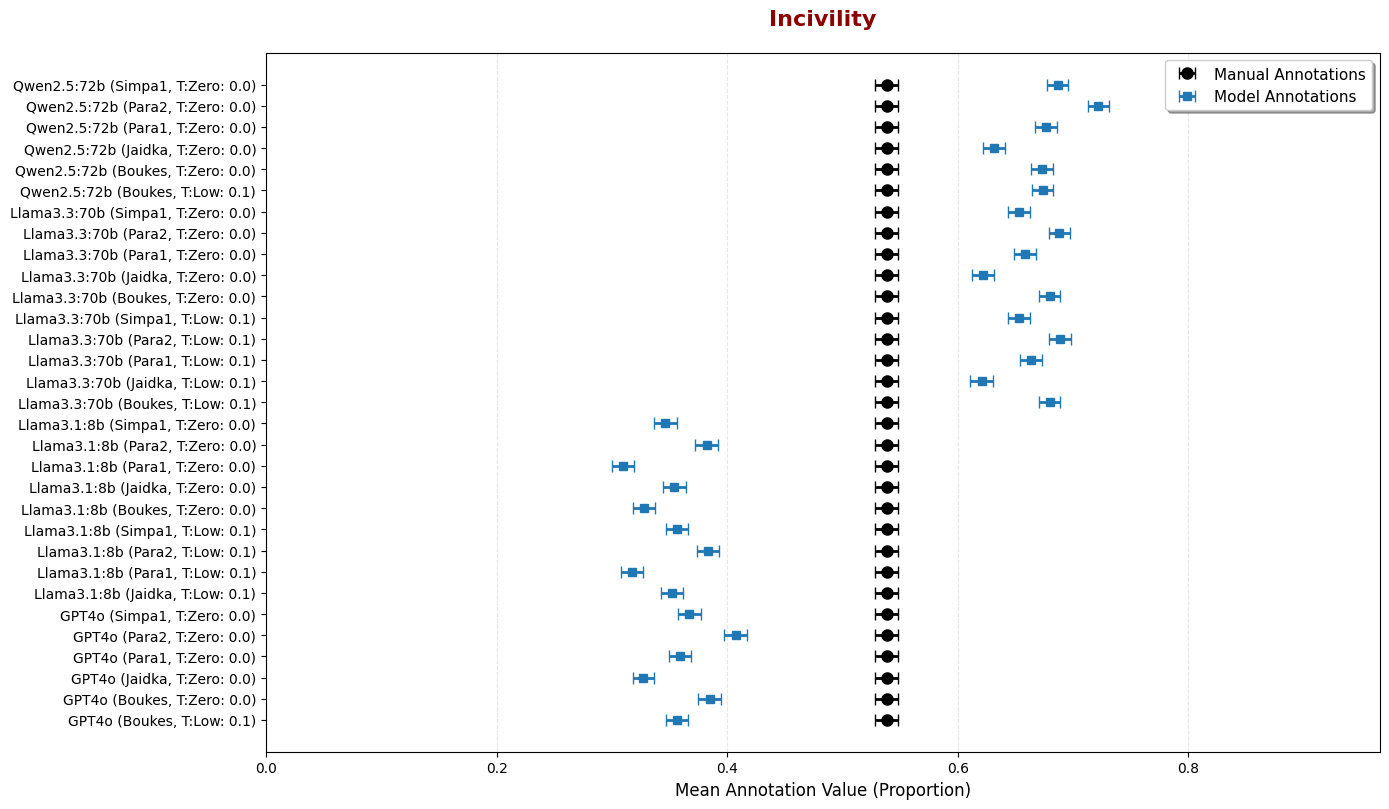

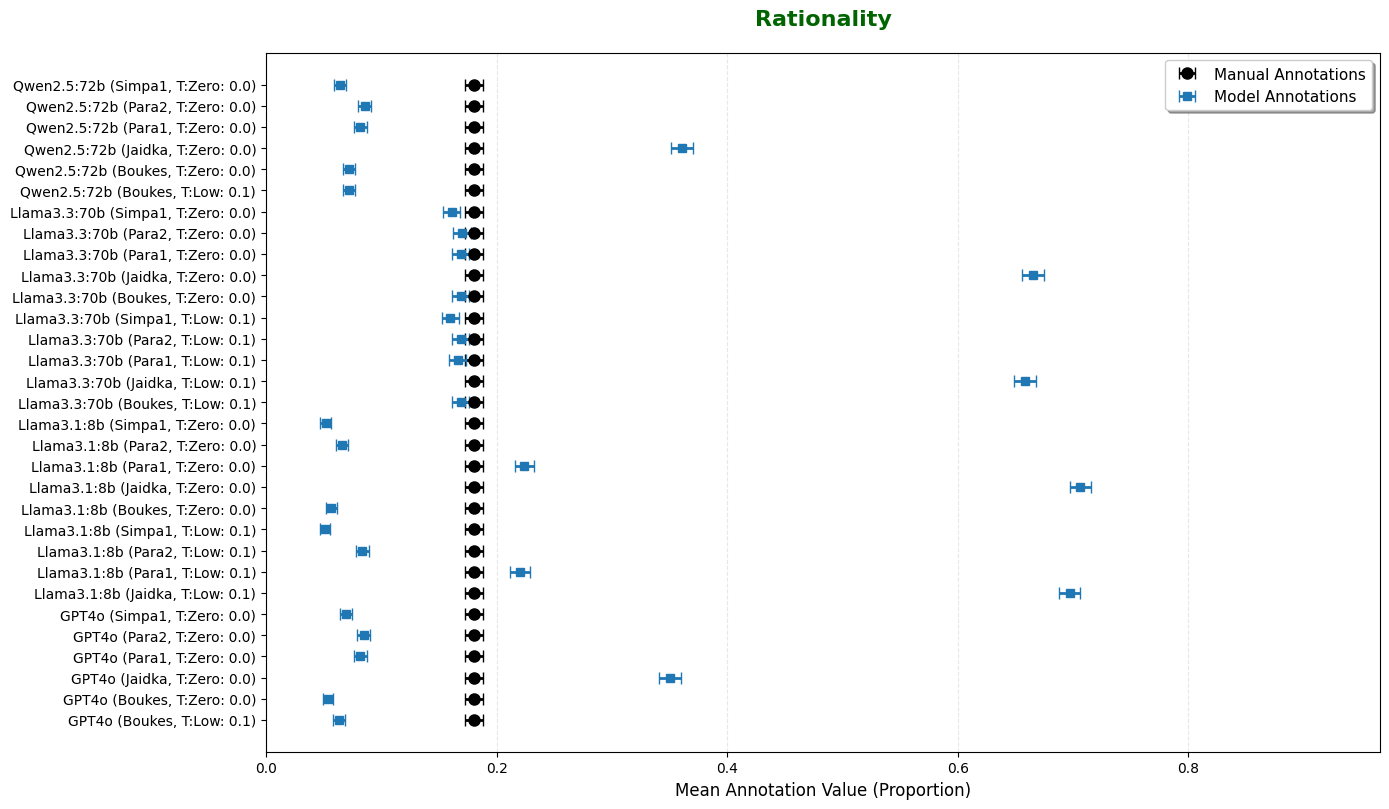

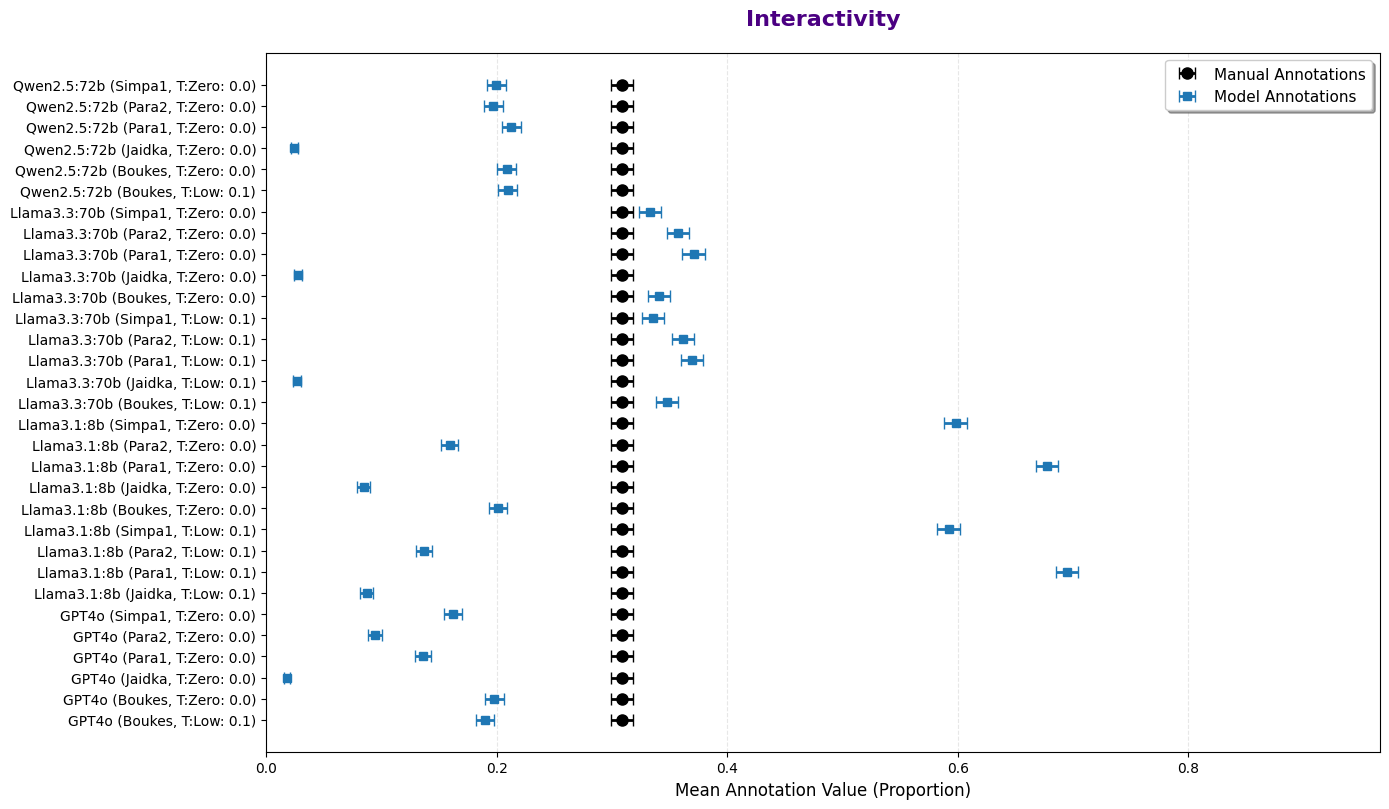

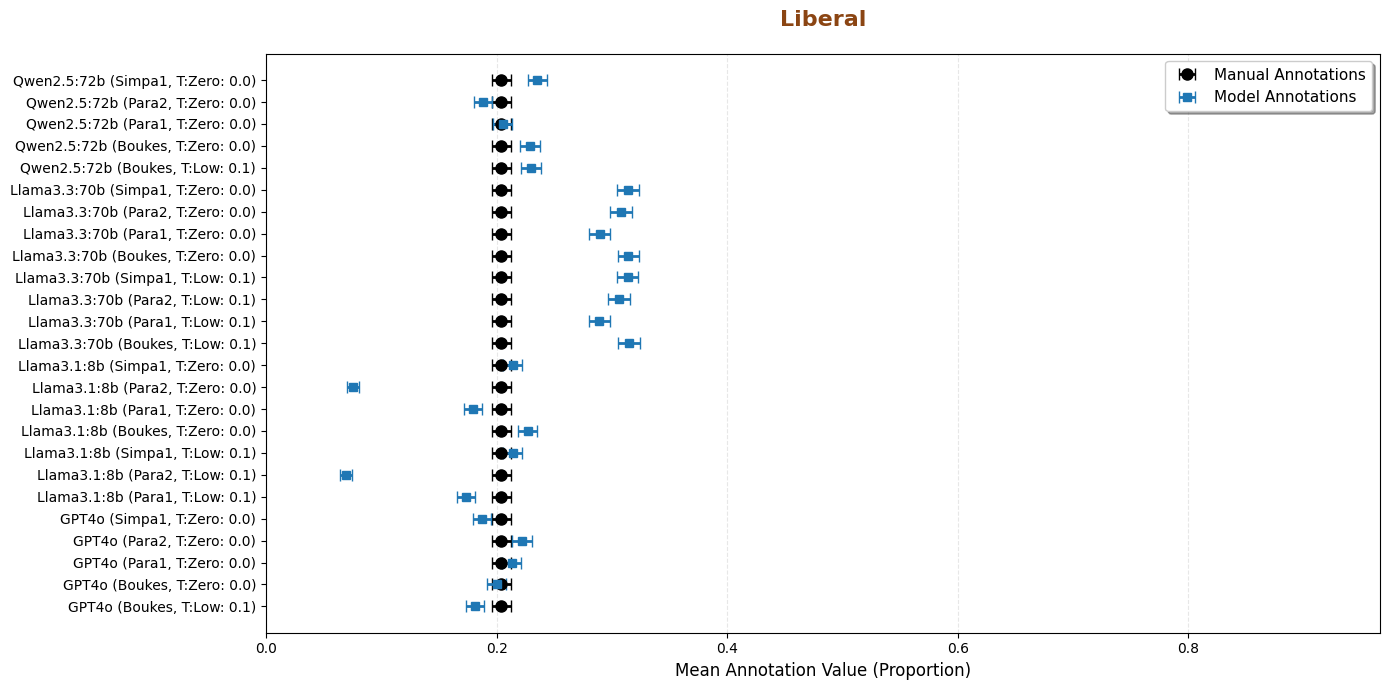

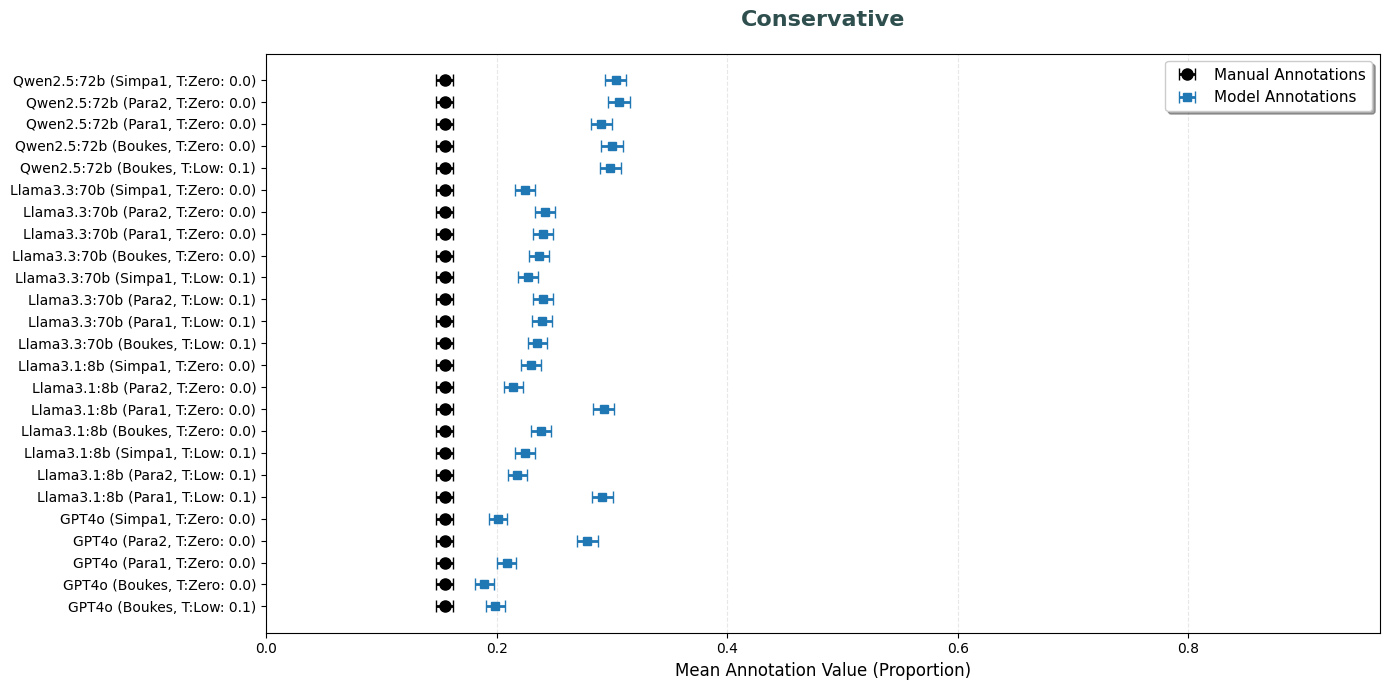

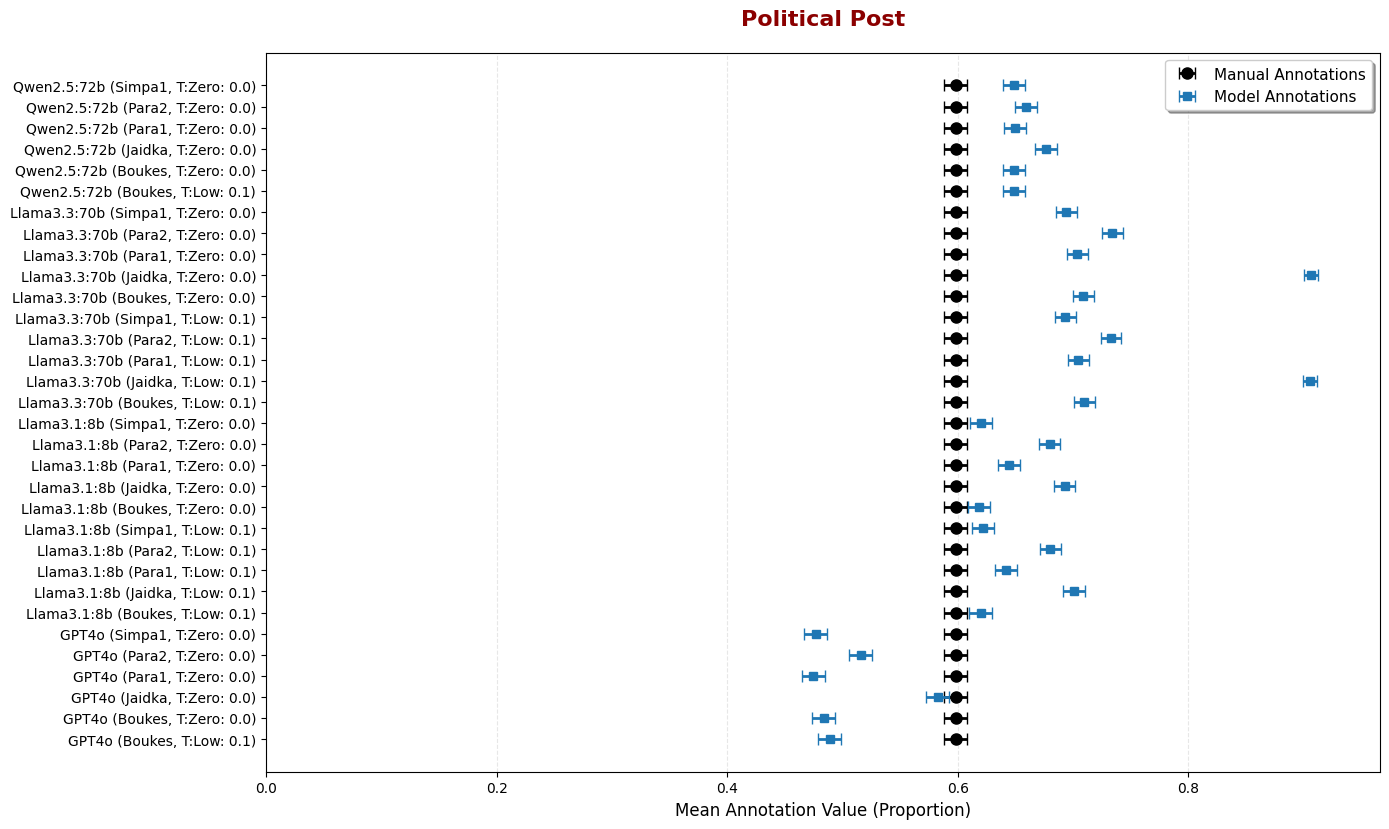

In [ ]:


# Function to plot model significance results as separate plots per concept
def plot_model_significance_results_with_ci(results_df):
    """
    Plot the significance results of models compared to manual annotations.
    Each concept gets its own separate plot with model and manual annotations displayed correctly.
    
    Parameters:
    - results_df: DataFrame containing significance results for each model column
    """
    
    if results_df.empty:
        print("No results to plot.")
        return
    
    # Create a copy to avoid modifying the original DataFrame
    df_plot = results_df.copy()
    
    # Prepare the data for plotting
    df_plot['model_label'] = df_plot.apply(
        lambda row: f"{row['model']} ({row['prompt_variant']}, T:{row['temperature']})", axis=1
    )
    
    # Get unique concepts
    concepts = df_plot['concept'].unique()
    
    # Calculate global x-axis limits to ensure consistency across all plots
    global_x_min = min(df_plot['manual_mean'].min() - df_plot['manual_std'].max(),
                       df_plot['model_mean'].min() - df_plot['model_std'].max()) - 0.02
    global_x_max = min(1.0, max(df_plot['manual_mean'].max() + df_plot['manual_std'].max(),
                               df_plot['model_mean'].max() + df_plot['model_std'].max()) + 0.05)
    global_x_min = max(0.0, global_x_min)  # Don't go below 0.0
    
    concept_colors = ['#8B0000', '#006400', '#4B0082', '#8B4513', '#2F4F4F']
    
    # Create separate plot for each concept
    for concept_idx, concept in enumerate(concepts):
        concept_data = df_plot[df_plot['concept'] == concept]
        
        # Sort the data by model, temperature, prompt_variant
        concept_data = concept_data.sort_values(['model', 'temperature', 'prompt_variant'])
        
        concept_color = concept_colors[concept_idx % len(concept_colors)]
        
        # Calculate figure height based on number of models
        row_height = 0.2
        fig_height = max(4, len(concept_data) * row_height + 2)
        
        # Create individual plot
        plt.figure(figsize=(14, fig_height))
        
        y_positions = range(len(concept_data))
        
        for i, (idx, row) in enumerate(concept_data.iterrows()):
            y_pos = i
            
            # Plot manual mean with confidence interval (standard error)
            plt.errorbar(
                x=row['manual_mean'],
                y=y_pos,
                xerr=row['manual_std'],
                fmt='o',
                label='Manual Annotations' if i == 0 else "",
                color='black',
                capsize=4,
                markersize=8,
                linewidth=2,
                zorder=3
            )
            
            # Plot model mean with confidence interval (standard error)
            plt.errorbar(
                x=row['model_mean'],
                y=y_pos,
                xerr=row['model_std'],
                fmt='s',
                label='Model Annotations' if i == 0 else "",
                color='#1f77b4',
                capsize=4,
                markersize=6,
                linewidth=2,
                zorder=3
            )
        
        # Set y-tick labels with better spacing
        plt.yticks(y_positions, [row['model_label'] for _, row in concept_data.iterrows()], fontsize=10)
        
        # Styling for each plot
        plt.title(f'{concept}', fontsize=16, fontweight='bold', color=concept_color, pad=20)
        plt.xlabel('Mean Annotation Value (Proportion)', fontsize=12)
        plt.grid(True, axis='x', alpha=0.3, linestyle='--')
        
        # Set consistent x-axis limits across all plots
        plt.xlim(global_x_min, global_x_max)
        
        # Ensure adequate spacing between y-tick labels
        plt.margins(y=0.05)
        
        # Add legend to each plot
        plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=11)
        
        plt.tight_layout()
        
        # Show the plot
        plt.show()

# Plot the significance results
plot_model_significance_results_with_ci(final_results_df)
    

In [ ]:
#

In [13]:
# Statistical tests to compare two crosstabs


# McNemar test implementation (since it's not in scipy.stats)
def mcnemar_test(table):
    """
    Perform McNemar's test for paired nominal data.
    
    Parameters:
    - table: 2x2 contingency table as numpy array or list
    
    Returns:
    - statistic: McNemar test statistic
    - p_value: p-value of the test
    """
    table = np.array(table)
    if table.shape != (2, 2):
        raise ValueError("Table must be 2x2")
    
    # McNemar test statistic
    b, c = table[0, 1], table[1, 0]
    
    if b + c == 0:
        return 0.0, 1.0
    
    # With continuity correction
    statistic = (abs(b - c) - 1)**2 / (b + c)
    
    # p-value from chi-square distribution with 1 df
    from scipy.stats import chi2
    p_value = 1 - chi2.cdf(statistic, df=1)
    
    return statistic, p_value

def compare_crosstabs_statistical_tests(manual_data, model_data, genre_column='genre_paper'):
    """
    Perform statistical tests to compare two crosstabs.
    
    Parameters:
    - manual_data: DataFrame column with manual annotations (binary)
    - model_data: DataFrame column with model annotations (binary)
    - genre_column: Column name for genre categories
    
    Returns:
    - Dictionary with test results and DataFrames
    """
    
    # Create crosstabs
    manual_crosstab = pd.crosstab(manual_data, boukes[genre_column])
    model_crosstab = pd.crosstab(model_data, boukes[genre_column])
    
    print("Manual Crosstab:")
    print(manual_crosstab)
    print("\nModel Crosstab:")
    print(model_crosstab)
    
    results = {}
    test_results_list = []  # List to store all test results for DataFrame
    
    
    # 2. McNemar's test (for paired data if same observations)
    try:
        # Create contingency table for paired comparisons
        paired_table = pd.crosstab(manual_data, model_data)
        print(f"\n2. Paired comparison table:")
        print(paired_table)
        
        if paired_table.shape == (2, 2):
            mcnemar_stat, mcnemar_p = mcnemar_test(paired_table.values)
            results['mcnemar'] = {
                'statistic': mcnemar_stat,
                'p_value': mcnemar_p,
                'interpretation': 'Tests if manual and model annotations differ significantly (paired data)'
            }
            
            # Add to DataFrame list
            test_results_list.append({
                'test_type': 'mcnemar',
                'genre': 'all',
                'statistic': mcnemar_stat,
                'p_value': mcnemar_p,
                'dof': 1,
                'manual_positive': None,
                'manual_total': None,
                'model_positive': None,
                'model_total': None,
                'manual_proportion': None,
                'model_proportion': None,
                'odds_ratio': None,
                'interpretation': 'Paired comparison test'
            })
            
            print(f"\n   McNemar test:")
            print(f"   Chi2 = {mcnemar_stat:.4f}, p = {mcnemar_p:.4f}")
            print(f"   Interpretation: {'Significant difference' if mcnemar_p < 0.05 else 'No significant difference'} between manual and model")
    except Exception as e:
        print(f"McNemar test failed: {e}")
    
    # 3. Fisher's exact test for each genre category
    print(f"\n3. Fisher's exact tests by genre:")
    fisher_results = {}
    
    for genre in manual_crosstab.columns:
        # Create 2x2 table for this genre
        manual_pos = manual_crosstab.loc[1, genre] if 1 in manual_crosstab.index else 0
        manual_neg = manual_crosstab.loc[0, genre] if 0 in manual_crosstab.index else 0
        model_pos = model_crosstab.loc[1, genre] if 1 in model_crosstab.index else 0
        model_neg = model_crosstab.loc[0, genre] if 0 in model_crosstab.index else 0
        
        manual_total = manual_pos + manual_neg
        model_total = model_pos + model_neg
        manual_prop = manual_pos / manual_total if manual_total > 0 else 0
        model_prop = model_pos / model_total if model_total > 0 else 0
        
        table_2x2 = [[manual_pos, manual_neg], [model_pos, model_neg]]
        
        try:
            odds_ratio, fisher_p = fisher_exact(table_2x2)
            fisher_results[genre] = {
                'odds_ratio': odds_ratio,
                'p_value': fisher_p,
                'manual_positive': manual_pos,
                'manual_total': manual_total,
                'model_positive': model_pos,
                'model_total': model_total
            }
            
            # Add to DataFrame list
            test_results_list.append({
                'test_type': 'fisher_exact',
                'genre': genre,
                'statistic': None,
                'p_value': fisher_p,
                'dof': None,
                'manual_positive': manual_pos,
                'manual_total': manual_total,
                'model_positive': model_pos,
                'model_total': model_total,
                'manual_proportion': manual_prop,
                'model_proportion': model_prop,
                'odds_ratio': odds_ratio,
                'interpretation': f'Fisher exact test for {genre}'
            })
            
            print(f"   {genre}: OR = {odds_ratio:.3f}, p = {fisher_p:.4f}")
        except Exception as e:
            print(f"   {genre}: Fisher test failed - {e}")
    
    results['fisher_by_genre'] = fisher_results
    
    # 4. Proportion tests for each genre
    print(f"\n4. Proportion tests by genre:")
    from statsmodels.stats.proportion import proportions_ztest
    
    prop_results = {}
    for genre in manual_crosstab.columns:
        manual_pos = manual_crosstab.loc[1, genre] if 1 in manual_crosstab.index else 0
        manual_total = manual_crosstab.loc[:, genre].sum()
        model_pos = model_crosstab.loc[1, genre] if 1 in model_crosstab.index else 0
        model_total = model_crosstab.loc[:, genre].sum()
        
        manual_prop = manual_pos / manual_total if manual_total > 0 else 0
        model_prop = model_pos / model_total if model_total > 0 else 0
        
        if manual_total > 0 and model_total > 0:
            try:
                z_stat, prop_p = proportions_ztest([manual_pos, model_pos], [manual_total, model_total])
                prop_results[genre] = {
                    'z_statistic': z_stat,
                    'p_value': prop_p,
                    'manual_prop': manual_prop,
                    'model_prop': model_prop
                }
                
                # Add to DataFrame list
                test_results_list.append({
                    'test_type': 'proportion_test',
                    'genre': genre,
                    'statistic': z_stat,
                    'p_value': prop_p,
                    'dof': None,
                    'manual_positive': manual_pos,
                    'manual_total': manual_total,
                    'model_positive': model_pos,
                    'model_total': model_total,
                    'manual_proportion': manual_prop,
                    'model_proportion': model_prop,
                    'odds_ratio': None,
                    'interpretation': f'Proportion test for {genre}'
                })
                
                print(f"   {genre}: Z = {z_stat:.3f}, p = {prop_p:.4f} (Manual: {manual_prop:.3f}, Model: {model_prop:.3f})")
            except Exception as e:
                print(f"   {genre}: Proportion test failed - {e}")
    
    results['proportion_tests'] = prop_results
    
    # Create DataFrame from results
    results_df = pd.DataFrame(test_results_list)
    results['results_dataframe'] = results_df
    
    print(f"\n" + "="*60)
    print("SUMMARY RESULTS DATAFRAME:")
    print("="*60)
    print(results_df)
    
    return results



In [14]:
# Function to create comprehensive summary table for all models and concepts
def create_comprehensive_crosstab_summary(boukes_data, concepts_info, model_columns, genre_column='genre_paper'):
    """
    Create a single summary table with crosstab test results for all models across all concepts.
    
    Parameters:
    - boukes_data: DataFrame containing the data
    - concepts_info: List of tuples (concept_name, manual_column)
    - model_columns: List of model column names
    - genre_column: Column name for genre categories
    
    Returns:
    - DataFrame with comprehensive results
    """
    
    all_results = []
    
    print("Running comprehensive crosstab analysis...")
    print("="*60)
    
    for concept, manual_col in concepts_info:
        print(f"\nProcessing concept: {concept}")
        print("-" * 40)
        
        # Get model columns for this concept
        concept_model_cols = [col for col in model_columns if get_labels(col)['concept'] == concept]
        
        if not concept_model_cols:
            print(f"No model columns found for concept: {concept}")
            continue
            
        if manual_col not in boukes_data.columns:
            print(f"Manual column {manual_col} not found for concept: {concept}")
            continue
        
        for model_col in concept_model_cols:
            try:
                # Get model information
                labels = get_labels(model_col)
                model_name = labels['model']
                prompt_variant = labels['prompt_variant']
                temperature = labels.get('temperature', 'N/A')
                
                print(f"  Testing model: {model_name} ({prompt_variant}, Temp: {temperature})")
                
                # Run the statistical tests
                test_results = compare_crosstabs_statistical_tests(
                    manual_data=boukes_data[manual_col],
                    model_data=boukes_data[model_col],
                    genre_column=genre_column
                )
                
                # Get the results DataFrame
                results_df = test_results['results_dataframe'].copy()
                
                # Add concept and model information to each row
                results_df['concept'] = concept
                results_df['manual_column'] = manual_col
                results_df['model_column'] = model_col
                results_df['model_name'] = model_name
                results_df['prompt_variant'] = prompt_variant
                results_df['temperature'] = temperature
                
                # Add to the comprehensive list
                all_results.append(results_df)
                
            except Exception as e:
                print(f"    Error processing {model_col}: {e}")
                continue
    
    # Combine all results into a single DataFrame
    if all_results:
        comprehensive_df = pd.concat(all_results, ignore_index=True)
        
        # Format p-values: round to 3 decimal places and show "< 0.001" for very small values
        def format_p_value(p_val):
            if pd.isna(p_val):
                return p_val
            elif p_val < 0.001:
                return "< 0.001"
            else:
                return round(p_val, 3)
        
        # Create a formatted p-value column
        comprehensive_df['p_value_formatted'] = comprehensive_df['p_value'].apply(format_p_value)
        
        # Round other numerical columns to 3 decimal places
        numerical_cols = ['statistic', 'manual_proportion', 'model_proportion', 'odds_ratio']
        for col in numerical_cols:
            if col in comprehensive_df.columns:
                comprehensive_df[col] = comprehensive_df[col].round(3)
        
        # Reorder columns for better readability
        column_order = [
            'concept', 'model_name', 'prompt_variant', 'temperature', 'model_column',
            'test_type', 'genre', 'statistic', 'p_value_formatted', 'p_value', 'dof',
            'manual_positive', 'manual_total', 'manual_proportion',
            'model_positive', 'model_total', 'model_proportion',
            'odds_ratio', 'interpretation', 'manual_column'
        ]
        
        # Only include columns that exist in the DataFrame
        available_columns = [col for col in column_order if col in comprehensive_df.columns]
        comprehensive_df = comprehensive_df[available_columns]
        
        print(f"\n" + "="*80)
        print("COMPREHENSIVE CROSSTAB ANALYSIS SUMMARY")
        print("="*80)
        print(f"Total test results: {len(comprehensive_df)}")
        print(f"Concepts analyzed: {len(comprehensive_df['concept'].unique())}")
        print(f"Models analyzed: {len(comprehensive_df['model_column'].unique())}")
        print(f"Test types: {comprehensive_df['test_type'].unique()}")
        
        # Summary statistics
        print(f"\nSignificant results (p < 0.05): {len(comprehensive_df[comprehensive_df['p_value'] < 0.05])}")
        print(f"Highly significant results (p < 0.01): {len(comprehensive_df[comprehensive_df['p_value'] < 0.01])}")
        print(f"Very highly significant results (p < 0.001): {len(comprehensive_df[comprehensive_df['p_value'] < 0.001])}")
        
        # Display some example formatted p-values
        print(f"\nExample p-value formatting:")
        sample_p_values = comprehensive_df[['test_type', 'genre', 'p_value', 'p_value_formatted']].head(10)
        print(sample_p_values)
        
        return comprehensive_df
    else:
        print("No results were generated.")
        return pd.DataFrame()



# Run comprehensive analysis
print("Starting comprehensive crosstab analysis...")
comprehensive_results = create_comprehensive_crosstab_summary(
    boukes_data=boukes2024,
    concepts_info=boukes_concepts_info,
    model_columns=model_columns_alltemps,
    genre_column='genre_paper'
)

print("\nComprehensive crosstab analysis completed.")
print(f"Total results: {len(comprehensive_results)}")
print(comprehensive_results.head())

Starting comprehensive crosstab analysis...
Running comprehensive crosstab analysis...

Processing concept: Incivility
----------------------------------------
  Testing model: GPT4o (Boukes, Temp: Zero: 0.0)
Manual Crosstab:
genre_paper       conservative partisan news  liberal partisan news  \
INCIVILITY_DUMMY                                                      
0                                        184                    181   
1                                        294                    286   

genre_paper       regular news  satire  
INCIVILITY_DUMMY                        
0                          318     452  
1                          345     399  

Model Crosstab:
genre_paper                               conservative partisan news  \
incivility_simple2_gpt4o_system_zero_dum                               
0                                                                263   
1                                                                215   

genre_paper        

In [ ]:
comprehensive_results

In [ ]:
#now replicate the analysis in the paper
#mulitlevel logistic regression analysis
#comments (rows) nested in shows (showName)
#dependent variable is the concept [interactivity, political post, rationality] -> only use the boukes prompt, zero temperature of the best model in terms of F1 score per concept
#independent variables are the genre_paper (-> categorical variable), the year  (Time_comment_year) , and topic ('topic'-> categorical variable), as well as the annotations of the same model for the other concepts (e.g., interactivity, political post, rationality, liberal and conservative) -> use the boukes prompt, zero temperature of the best model in terms of F1 score per concept



In [8]:
#calculate the F1 macro score for each prompt variant, temperature and model per concept
# Create a dictionary from the boukes_concepts_info list for easy lookup
concepts_dict = dict(boukes_concepts_info)

# Initialize list to store results
results = []

for col in model_columns_alltemps:
    labels = get_labels(col)
    concept = labels['concept']
    gt_col = concepts_dict.get(concept, None)
    if gt_col is None:
        print(f"Warning: No ground truth column found for concept '{concept}' in column '{col}'")
        continue
    model = labels['model']
    prompt_variant = labels['prompt_variant']
    temperature = labels.get('temperature', 'N/A')
    
    # Calculate F1 macro score
    f1_macro = get_macro_f1_score(boukes2024, col, gt_col)
    
    # Store results in list
    results.append({
        'concept': concept,
        'column_name': col,
        'model': model,
        'prompt_variant': prompt_variant,
        'temperature': temperature,
        'macro_f1': f1_macro
    })
    
    print(f"F1 Macro Score for {concept} ({model}, {prompt_variant}, Temp: {temperature}): {f1_macro:.4f}")

# Create dataframe from results
concept_model_f1_df = pd.DataFrame(results)

# Sort by concept and then by macro_f1 descending within each concept
concept_model_f1_df = concept_model_f1_df.sort_values(['concept', 'macro_f1'], ascending=[True, False])

# Reset index for clean display
concept_model_f1_df = concept_model_f1_df.reset_index(drop=True)

print(f"\n{'='*80}")
print("F1 MACRO SCORES SUMMARY")
print('='*80)
print(f"Total evaluations: {len(concept_model_f1_df)}")
print(f"Concepts evaluated: {concept_model_f1_df['concept'].nunique()}")
print(f"Models tested: {concept_model_f1_df['model'].nunique()}")
print(f"Prompt variants: {concept_model_f1_df['prompt_variant'].nunique()}")

# Display the dataframe
print(f"\nConcept-Model F1 Performance (sorted by concept, then F1 descending):")
print(concept_model_f1_df.to_string(index=False, float_format='%.4f'))

# Show best performing model per concept
print(f"\n{'='*80}")
print("BEST PERFORMING MODEL PER CONCEPT")
print('='*80)
best_per_concept = concept_model_f1_df.groupby('concept').first().reset_index()
for _, row in best_per_concept.iterrows():
    print(f"{row['concept']:15} | {row['model']:15} | {row['prompt_variant']:10} | {row['temperature']:10} | F1: {row['macro_f1']:.4f}")

print(f"\n{'='*80}")

F1 Macro Score for Incivility (GPT4o, Boukes, Temp: Zero: 0.0): 0.7390
F1 Macro Score for Rationality (GPT4o, Boukes, Temp: Zero: 0.0): 0.6347
F1 Macro Score for Interactivity (GPT4o, Boukes, Temp: Zero: 0.0): 0.7366
F1 Macro Score for Rationality (Llama3.3:70b, Boukes, Temp: Low: 0.1): 0.7261
F1 Macro Score for Incivility (Llama3.3:70b, Boukes, Temp: Low: 0.1): 0.7511
F1 Macro Score for Political Post (Llama3.3:70b, Boukes, Temp: Low: 0.1): 0.7924
F1 Macro Score for Rationality (Llama3.3:70b, Jaidka, Temp: Low: 0.1): 0.4943
F1 Macro Score for Incivility (Llama3.3:70b, Jaidka, Temp: Low: 0.1): 0.7480
F1 Macro Score for Political Post (Llama3.3:70b, Jaidka, Temp: Low: 0.1): 0.5746
F1 Macro Score for Conservative (Llama3.3:70b, Boukes, Temp: Low: 0.1): 0.7800
F1 Macro Score for Liberal (Llama3.3:70b, Boukes, Temp: Low: 0.1): 0.7608
F1 Macro Score for Conservative (Llama3.3:70b, Para1, Temp: Low: 0.1): 0.7817
F1 Macro Score for Liberal (Llama3.3:70b, Para1, Temp: Low: 0.1): 0.7740
F1 Macr

In [12]:
#make a dataframe based on the columns in boukes2024 with the best performing columns per concept based on concept_model_f1_df, the ground truth columns per concept based on boukes_concepts_info, 
# and the genre_paper column, the topic, the year  (Time_comment_year) 
# call this df logregres_df

#get the best performing model column per concept
best_model_columns = []
gt_columns = []

for concept in boukes_concepts_info:
    concept_name = concept[0]
    gt_col = concept[1]
    
    # Filter the DataFrame for the current concept
    concept_df = concept_model_f1_df[concept_model_f1_df['concept'] == concept_name]
    
    if len(concept_df) > 0:
        # Get the best performing model column for this concept (first row since it's sorted by F1 descending)
        best_model_col = concept_df.iloc[0]['column_name']
        best_model_columns.append(best_model_col)
        gt_columns.append(gt_col)
        print(f"Best model for {concept_name}: {best_model_col} (F1: {concept_df.iloc[0]['macro_f1']:.4f})")
    else:
        print(f"Warning: No models found for concept {concept_name}")

# Combine all columns needed for the regression dataframe
all_columns = ['genre_paper', 'topic', 'Time_comment_year', 'showName'] + best_model_columns + gt_columns

# Remove any columns that don't exist in boukes2024
existing_columns = [col for col in all_columns if col in boukes2024.columns]
missing_columns = [col for col in all_columns if col not in boukes2024.columns]

if missing_columns:
    print(f"Warning: Missing columns in boukes2024: {missing_columns}")

print(f"Creating logregres_df with {len(existing_columns)} columns: {existing_columns}")

# Create the regression dataframe
logregres_df = boukes2024[existing_columns].copy()

print(f"logregres_df shape: {logregres_df.shape}")
print(f"logregres_df columns: {list(logregres_df.columns)}")
print(f"\nFirst few rows:")
print(logregres_df.head())
    



Best model for Incivility: incivility_jaidka_Q25_72b_zero_dum (F1: 0.7617)
Best model for Rationality: rationality_simple2_para2_L33_70b_low_dum (F1: 0.7303)
Best model for Interactivity: interactivity_acknowledgement_simple_L33_70b_zero_dum (F1: 0.7692)
Best model for Liberal: political_ideology_US_para1_gpt4o_system_zero_lib_dum (F1: 0.7968)
Best model for Conservative: political_ideology_US_gpt4o_system_zero_con_dum (F1: 0.8167)
Best model for Political Post: political_post_jaidka_gpt4o_system_zero_dum (F1: 0.8377)
Creating logregres_df with 16 columns: ['genre_paper', 'topic', 'Time_comment_year', 'showName', 'incivility_jaidka_Q25_72b_zero_dum', 'rationality_simple2_para2_L33_70b_low_dum', 'interactivity_acknowledgement_simple_L33_70b_zero_dum', 'political_ideology_US_para1_gpt4o_system_zero_lib_dum', 'political_ideology_US_gpt4o_system_zero_con_dum', 'political_post_jaidka_gpt4o_system_zero_dum', 'INCIVILITY_DUMMY', 'RATIONALITY_DUMMY', 'INTERACTIVITY_DUMMY', 'LIBERAL_DUMMY', 'CO

In [20]:
# Prepare categorical variables efficiently
categorical_cols = ['genre_paper', 'Time_comment_year', 'topic']
logregres_df[categorical_cols] = logregres_df[categorical_cols].astype('category')

#set satire as reference category:
logregres_df['genre_paper'] = logregres_df['genre_paper'].cat.reorder_categories(
    ['satire'] + sorted([c for c in logregres_df['genre_paper'].cat.categories if c != 'satire'])
)

# Define formula with proper concatenation
formula = (
    "interactivity_acknowledgement_simple_L33_70b_zero_dum ~ "
    "rationality_simple2_para2_L33_70b_low_dum + "
    "C(genre_paper) + C(Time_comment_year) + C(topic) + "
    "political_ideology_US_para1_gpt4o_system_zero_lib_dum + "
    "incivility_jaidka_Q25_72b_zero_dum + "
    "political_ideology_US_gpt4o_system_zero_con_dum + "
    "political_post_jaidka_gpt4o_system_zero_dum "
)

# Specify random effects
random_effects = {"group_intercept": "0 + C(showName)"}

# Initialize and fit the model
model = BinomialBayesMixedGLM.from_formula(
    formula, 
    random_effects, 
    data=logregres_df
)
result = model.fit_map()

# Print the full summary
print(result.summary())


                                     Binomial Mixed GLM Results
                                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
----------------------------------------------------------------------------------------------------
Intercept                                                M    -0.3543   0.4272                      
C(genre_paper)[T.conservative partisan news]             M    -0.0796   0.1370                      
C(genre_paper)[T.liberal partisan news]                  M    -0.0205   0.1328                      
C(genre_paper)[T.regular news]                           M    -0.1992   0.1194                      
C(Time_comment_year)[T.2015]                             M     0.1230   0.5227                      
C(Time_comment_year)[T.2016]                             M     0.6563   0.4579                      
C(Time_comment_year)[T.2017]                             M    -0.1770   0.4471                      
C(Time_comment_year)[T.2018

In [ ]:

fe_mean = result.fe_mean
fe_sd = result.fe_sd

# Calculate z and p
z_scores = fe_mean / fe_sd
p_values = 2 * stats.norm.sf(abs(z_scores))

# Create DataFrame
results_table = pd.DataFrame({
    'Coefficient': fe_mean,
    'Std. Error': fe_sd,
    'z': z_scores,
    'P>|z|': p_values
})

# Try to get variable names (if available)
try:
    variable_names = result.fe_names
except AttributeError:
    try:
        # Try to get from model, if possible
        variable_names = model.exog_names
    except AttributeError:
        # Fallback: use generic names if nothing else works
        variable_names = [f'var_{i}' for i in range(len(fe_mean))]
        print("Warning: Could not get variable names from result or model. Using generic names.")

results_table.index = variable_names

# Format p-values
def format_pvalue(p):
    if p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"

results_table['P>|z|'] = results_table['P>|z|'].apply(format_pvalue)

print(results_table)


                                                       Coefficient  \
Intercept                                                -0.354277   
C(genre_paper)[T.conservative partisan news]             -0.079628   
C(genre_paper)[T.liberal partisan news]                  -0.020527   
C(genre_paper)[T.regular news]                           -0.199235   
C(Time_comment_year)[T.2015]                              0.123043   
C(Time_comment_year)[T.2016]                              0.656314   
C(Time_comment_year)[T.2017]                             -0.176958   
C(Time_comment_year)[T.2018]                             -0.064192   
C(Time_comment_year)[T.2019]                              0.021007   
C(topic)[T.economy]                                      -0.133066   
C(topic)[T.mueller]                                       0.075840   
rationality_simple2_para2_L33_70b_low_dum                 1.282648   
political_ideology_US_para1_gpt4o_system_zero_lib_dum     0.041538   
incivility_jaidka_Q2

In [28]:
#repeat with default annotations

#set satire as reference category:
boukes2024['genre_paper_cat'] = boukes2024['genre_paper'].astype('category')
boukes2024['genre_paper_cat'] = boukes2024['genre_paper_cat'].cat.reorder_categories(
    ['satire'] + sorted([c for c in boukes2024['genre_paper_cat'].cat.categories if c != 'satire'])
)

# Define formula with proper concatenation
formula = (
    "interactivity_acknowledgement_simple_L33_70b_zero_dum ~ "
    "rationality_simple2_L33_70b_zero_dum + "
    "C(genre_paper) + C(Time_comment_year) + C(topic) + "
    "political_ideology_US_L33_70b_zero_lib_dum + "
    "incivility_simple2_L33_70b_zero_dum + "
    "political_ideology_US_L33_70b_zero_con_dum + "
    "political_post_L33_70b_zero_dum "
)

# Specify random effects
random_effects = {"group_intercept": "0 + C(showName)"}

# Initialize and fit the model
model = BinomialBayesMixedGLM.from_formula(
    formula, 
    random_effects, 
    data=boukes2024 
)
result_L33_70b_zero = model.fit_map()

fe_mean = result_L33_70b_zero.fe_mean
fe_sd = result_L33_70b_zero.fe_sd

# Calculate z and p
z_scores = fe_mean / fe_sd
p_values = 2 * stats.norm.sf(abs(z_scores))

# Create DataFrame
results_table_L33_70b_zero = pd.DataFrame({
    'Coefficient': fe_mean,
    'Std. Error': fe_sd,
    'z': z_scores,
    'P>|z|': p_values
})

# Try to get variable names (if available)
try:
    variable_names = result.fe_names
except AttributeError:
    try:
        # Try to get from model, if possible
        variable_names = model.exog_names
    except AttributeError:
        # Fallback: use generic names if nothing else works
        variable_names = [f'var_{i}' for i in range(len(fe_mean))]
        print("Warning: Could not get variable names from result or model. Using generic names.")

results_table_L33_70b_zero.index = variable_names

# Format p-values
def format_pvalue(p):
    if p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"

results_table_L33_70b_zero['P>|z|'] = results_table_L33_70b_zero['P>|z|'].apply(format_pvalue)

print(results_table_L33_70b_zero)

                                            Coefficient  Std. Error  \
Intercept                                     -0.409159    0.446960   
C(genre_paper)[T.liberal partisan news]        0.029756    0.146307   
C(genre_paper)[T.regular news]                -0.153226    0.137440   
C(genre_paper)[T.satire]                       0.066250    0.136771   
C(Time_comment_year)[T.2015]                   0.233461    0.522955   
C(Time_comment_year)[T.2016]                   0.712035    0.457560   
C(Time_comment_year)[T.2017]                  -0.167577    0.446286   
C(Time_comment_year)[T.2018]                  -0.022980    0.432070   
C(Time_comment_year)[T.2019]                   0.061584    0.431390   
C(topic)[T.economy]                           -0.136595    0.111264   
C(topic)[T.mueller]                            0.092986    0.111274   
rationality_simple2_L33_70b_zero_dum           1.330890    0.119965   
political_ideology_US_L33_70b_zero_lib_dum     0.179087    0.134658   
incivi

In [32]:
#repeat with gpt4o annotations

#repeat with default annotations

#set satire as reference category:
boukes2024['genre_paper_cat'] = boukes2024['genre_paper'].astype('category')
boukes2024['genre_paper_cat'] = boukes2024['genre_paper_cat'].cat.reorder_categories(
    ['satire'] + sorted([c for c in boukes2024['genre_paper_cat'].cat.categories if c != 'satire'])
)

# Define formula with proper concatenation
formula = (
    "interactivity_acknowledgement_simple_gpt4o_system_zero_dum ~ "
    "rationality_simple2_gpt4o_system_zero_dum + "
    "C(genre_paper) + C(Time_comment_year) + C(topic) + "
    "political_ideology_US_gpt4o_system_zero_lib_dum + "
    "incivility_simple2_gpt4o_system_zero_dum + "
    "political_ideology_US_gpt4o_system_zero_con_dum + "
    "political_post_gpt4o_system_zero_dum "
)

# Specify random effects
random_effects = {"group_intercept": "0 + C(showName)"}

# Initialize and fit the model
model = BinomialBayesMixedGLM.from_formula(
    formula, 
    random_effects, 
    data=boukes2024 
)
result_gpt4o_zero = model.fit_map()

fe_mean = result_gpt4o_zero.fe_mean
fe_sd = result_gpt4o_zero.fe_sd

# Calculate z and p
z_scores = fe_mean / fe_sd
p_values = 2 * stats.norm.sf(abs(z_scores))

# Create DataFrame
results_table_gpt4o_zero = pd.DataFrame({
    'Coefficient': fe_mean,
    'Std. Error': fe_sd,
    'z': z_scores,
    'P>|z|': p_values
})

# Try to get variable names (if available)
try:
    variable_names = result.fe_names
except AttributeError:
    try:
        # Try to get from model, if possible
        variable_names = model.exog_names
    except AttributeError:
        # Fallback: use generic names if nothing else works
        variable_names = [f'var_{i}' for i in range(len(fe_mean))]
        print("Warning: Could not get variable names from result or model. Using generic names.")

results_table_gpt4o_zero.index = variable_names

# Format p-values
def format_pvalue(p):
    if p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"

results_table_gpt4o_zero['P>|z|'] = results_table_gpt4o_zero['P>|z|'].apply(format_pvalue)

print(results_table_gpt4o_zero)

                                                 Coefficient  Std. Error  \
Intercept                                          -1.549647    0.500107   
C(genre_paper)[T.liberal partisan news]             0.136162    0.170783   
C(genre_paper)[T.regular news]                     -0.007692    0.159481   
C(genre_paper)[T.satire]                            0.121553    0.159820   
C(Time_comment_year)[T.2015]                        0.604506    0.575357   
C(Time_comment_year)[T.2016]                        0.766755    0.508940   
C(Time_comment_year)[T.2017]                       -0.166972    0.509192   
C(Time_comment_year)[T.2018]                       -0.162898    0.490304   
C(Time_comment_year)[T.2019]                        0.387066    0.487365   
C(topic)[T.economy]                                -0.066766    0.128713   
C(topic)[T.mueller]                                 0.103091    0.129109   
rationality_simple2_gpt4o_system_zero_dum           1.016448    0.196485   
political_id

In [33]:
#repeat for political post as DV:

# Prepare categorical variables efficiently
categorical_cols = ['genre_paper', 'Time_comment_year', 'topic']
logregres_df[categorical_cols] = logregres_df[categorical_cols].astype('category')

#set satire as reference category:
logregres_df['genre_paper'] = logregres_df['genre_paper'].cat.reorder_categories(
    ['satire'] + sorted([c for c in logregres_df['genre_paper'].cat.categories if c != 'satire'])
)

# Define formula with proper concatenation
formula = (
    "political_post_jaidka_gpt4o_system_zero_dum ~ "
    "rationality_simple2_para2_L33_70b_low_dum + "
    "C(genre_paper) + C(Time_comment_year) + C(topic) + "
    "political_ideology_US_para1_gpt4o_system_zero_lib_dum + "
    "incivility_jaidka_Q25_72b_zero_dum + "
    "political_ideology_US_gpt4o_system_zero_con_dum + interactivity_acknowledgement_simple_L33_70b_zero_dum"

)

# Specify random effects
random_effects = {"group_intercept": "0 + C(showName)"}

# Initialize and fit the model
model = BinomialBayesMixedGLM.from_formula(
    formula, 
    random_effects, 
    data=logregres_df
)
result = model.fit_map()

fe_mean = result.fe_mean
fe_sd = result.fe_sd

# Calculate z and p
z_scores = fe_mean / fe_sd
p_values = 2 * stats.norm.sf(abs(z_scores))

# Create DataFrame
results_table = pd.DataFrame({
    'Coefficient': fe_mean,
    'Std. Error': fe_sd,
    'z': z_scores,
    'P>|z|': p_values
})

# Try to get variable names (if available)
try:
    variable_names = result.fe_names
except AttributeError:
    try:
        # Try to get from model, if possible
        variable_names = model.exog_names
    except AttributeError:
        # Fallback: use generic names if nothing else works
        variable_names = [f'var_{i}' for i in range(len(fe_mean))]
        print("Warning: Could not get variable names from result or model. Using generic names.")

results_table.index = variable_names

# Format p-values
def format_pvalue(p):
    if p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"

results_table['P>|z|'] = results_table['P>|z|'].apply(format_pvalue)

print(results_table)



                                                       Coefficient  \
Intercept                                                -1.597866   
C(genre_paper)[T.conservative partisan news]              0.219458   
C(genre_paper)[T.liberal partisan news]                   0.421229   
C(genre_paper)[T.regular news]                           -0.023694   
C(Time_comment_year)[T.2015]                             -0.051485   
C(Time_comment_year)[T.2016]                             -0.071684   
C(Time_comment_year)[T.2017]                              0.094651   
C(Time_comment_year)[T.2018]                              0.321334   
C(Time_comment_year)[T.2019]                              0.564259   
C(topic)[T.economy]                                      -0.685773   
C(topic)[T.mueller]                                       0.031060   
rationality_simple2_para2_L33_70b_low_dum                 1.906800   
political_ideology_US_para1_gpt4o_system_zero_lib_dum     3.108392   
incivility_jaidka_Q2

In [35]:
#repeat for political post as DV:

# Prepare categorical variables efficiently
categorical_cols = ['genre_paper', 'Time_comment_year', 'topic']
logregres_df[categorical_cols] = logregres_df[categorical_cols].astype('category')

#set satire as reference category:
logregres_df['genre_paper'] = logregres_df['genre_paper'].cat.reorder_categories(
    ['satire'] + sorted([c for c in logregres_df['genre_paper'].cat.categories if c != 'satire'])
)

# Define formula with proper concatenation
formula = (
    "rationality_simple2_para2_L33_70b_low_dum ~ "
    "C(genre_paper) + C(Time_comment_year) + C(topic) + "
    "political_ideology_US_para1_gpt4o_system_zero_lib_dum + "
    "incivility_jaidka_Q25_72b_zero_dum + "
    "political_ideology_US_gpt4o_system_zero_con_dum + interactivity_acknowledgement_simple_L33_70b_zero_dum + "
    "political_post_jaidka_gpt4o_system_zero_dum"
)

# Specify random effects
random_effects = {"group_intercept": "0 + C(showName)"}

# Initialize and fit the model
model = BinomialBayesMixedGLM.from_formula(
    formula, 
    random_effects, 
    data=logregres_df
)
result = model.fit_map()

fe_mean = result.fe_mean
fe_sd = result.fe_sd

# Calculate z and p
z_scores = fe_mean / fe_sd
p_values = 2 * stats.norm.sf(abs(z_scores))

# Create DataFrame
results_table = pd.DataFrame({
    'Coefficient': fe_mean,
    'Std. Error': fe_sd,
    'z': z_scores,
    'P>|z|': p_values
})

# Try to get variable names (if available)
try:
    variable_names = result.fe_names
except AttributeError:
    try:
        # Try to get from model, if possible
        variable_names = model.exog_names
    except AttributeError:
        # Fallback: use generic names if nothing else works
        variable_names = [f'var_{i}' for i in range(len(fe_mean))]
        print("Warning: Could not get variable names from result or model. Using generic names.")

results_table.index = variable_names

# Format p-values
def format_pvalue(p):
    if p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"

results_table['P>|z|'] = results_table['P>|z|'].apply(format_pvalue)

print(results_table)



                                                       Coefficient  \
Intercept                                                -2.423652   
C(genre_paper)[T.conservative partisan news]             -0.153293   
C(genre_paper)[T.liberal partisan news]                  -0.387281   
C(genre_paper)[T.regular news]                            0.095891   
C(Time_comment_year)[T.2015]                             -0.023180   
C(Time_comment_year)[T.2016]                              0.132277   
C(Time_comment_year)[T.2017]                              0.073830   
C(Time_comment_year)[T.2018]                             -0.553528   
C(Time_comment_year)[T.2019]                             -0.804931   
C(topic)[T.economy]                                      -0.093338   
C(topic)[T.mueller]                                      -0.157609   
political_ideology_US_para1_gpt4o_system_zero_lib_dum     0.885119   
incivility_jaidka_Q25_72b_zero_dum                       -1.148394   
political_ideology_U